In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import pipeline as p
from os import chdir; chdir('/Users/albertwakhloo/Desktop/theoretical_neuroscience/neuromatch/steinmetz full/allData/all dat')
from jupyterthemes import jtplot ; jtplot.style() 

In [205]:
folders = glob('*')
f = ['Moniz_2017-05-16']#folders[5:6]
spikes_raw, stim, neur = p.pipeline(f, truncate = 20000, bin_size = 0.02, mr_clean = False) 

Getting spike time data ...
Moniz_2017-05-16
Mapping neurons from Moniz_2017-05-16 to channels ... 
Mapping channels to brain areas ...
Getting behavioral data ...
~~~ OOOoOOOOooOoOOOOOOOOOOoooOooOOOOOOo ~~~
Forming groups ... 
Forming spike trains ...
Forming stimulus series ...
Creating data-frame ...
~~~ the power of christ literally compels you ~~~


In [206]:
neur.area.unique()

array(['TH', 'LGd', 'DG', 'CA1', 'VISa', 'MG', 'VISp', 'SUB', 'SPF', 'LP',
       'root'], dtype=object)

In [207]:
folders = glob('*')
relevant_n = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl",
             "CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"]
#p.filt(folders, regions_to_pull = relevant_n)

In [208]:
labels = []
neur['labels'] = neur.area.astype('category')
for neuro in neur.neuron.unique() : 
    labels.append(neur[neur.neuron == neuro].labels.cat.codes.unique()[0])

In [209]:
chdir('/Users/albertwakhloo/Desktop/models/pyro and pytorch')

In [210]:
def stim_filler(spk_df) : 
    '''fills out stim times to cover the length of the trial. 
    Args : spike_df, a frequency transform object obtained from the pipeline function
    Returns : spike_df but with all of the stimulus times filled out, instead of just onset times
    '''
    response_t = spk_df[spk_df.response != 0].index
    stim_onset = spk_df[spk_df.stim != 0].index
    nearest_stim = np.zeros(len(response_t))

    for i, time in enumerate(response_t) : 
        '''grab indices of the closest stim == 1 entry for each response. necessary to reshape'''
        nearest_stim[i] = stim_onset[stim_onset < time][-1]
    nearest_stim = nearest_stim.astype(int)
    spikes = spk_df.copy()
    stim_fill = np.zeros(spikes.shape[0])
    cr = spikes.contrast_right.values
    cl = spikes.contrast_left.values  
    
    for onset, response in zip(nearest_stim, response_t) : 
        stim_fill[onset:response + 1] = 1 #add one so that we still have stim type at t of reaction
        cr[onset:response + 1] = cr[onset]
        cl[onset:response + 1] = cl[onset]
    
    spikes['filled_stim'] = stim_fill
    spikes['contrast_right'] = cr
    spikes['contrast_left'] = cl
    return spikes

you need to figure out what is going on with having to change type to int. the d-type should be invariant

In [211]:
def nearest_stim(response_t_indices, stim_onset_indices) : 
    '''Returns an array of indices the same size as response_t_indices containing the indices
    of the closest time in a larger spike_df where stim was 1. This is a horrible sentence.
    Basically this function takes a response time and tells you where in the data set was
    the stimulus onset time. No need to call this function for any reason.'''
    nearest_stim = np.zeros(len(response_t_indices))
    for i, time in enumerate(response_t_indices) : 
        '''grab indices of the closest stim == 1 entry for each response. necessary to reshape'''
        nearest_stim[i] = stim_onset_indices[stim_onset_indices < time][-1]
    return nearest_stim.astype(int)

where do we drop no gos? 

In [389]:
def trial_tensors(spks_df, chunk_behavior = False,
                 chunk_spikes = False, get_rt = False, lunacy= False, bin_size = 0.02) : 
    '''Form trial tuples for LSTM. This is a necessary step to form time series chunks that we
    can then pass to pytorch.
    Args : spks_df, a spike dataframe which has already been passed through the stimulus filler
        chunk_behavior : whether to form the chunks out of behavioral data. The idea is that
        well eventually be able to use this for the full  behavioral dat.
        chunk_spikes : use this. chunks the spiking data into the trials.
        get_rt : whether the outcome variable should contain the rt
        bin_size : whatever bin_size you used when you called pipeline.
        lunacy : introduce a halfway cut to the time series'''
    trial_tups = []
    #if lunacy == True : trial_tups = [[], []]
    resp = spks_df[spks_df.response != 0].index
    nearest_st = nearest_stim(resp, 
                             spks_df[spks_df.stim != 0].index) # get chunk indices
    for start, end in zip(nearest_st, resp) : 
        trl_slice = spks_df.iloc[start:end + 1]
        if trl_slice.iloc[-1].response == 999 : continue #don't grab no gos
            
        if chunk_behavior == True : 
            #eventually we'll be grabbing more than just the contrasts. In reality we don't
            #even need this function, as it'd be way more efficient to do this without chunking
            stim_trl_slice = trl_slice.loc[:, ['contrast_left', 'contrast_right']].values.astype(float)
            if get_rt == True : #make the outcome tensor out of rt + choice
                behavioral_re = np.array([float(stim_trl_slice.shape[0]) * bin_size,
                                          trl_slice.loc[:, 'response'].values[-1]])

            else : 
                behavioral_re = trl_slice.loc[:, 'response'].values.astype(float)
                #print(behavioral_re[-1])
                
            stim_trl_slice = torch.tensor(stim_trl_slice, requires_grad = True).float()
            behavioral_re = torch.tensor(behavioral_re, requires_grad = True).float()
            if lunacy == True : 
                trial_tups[0].append(stim_trl_slice) 
                trial_tups[1].append(behavioral_re)
            else :
                trial_tups.append((stim_trl_slice, behavioral_re))
            
        elif chunk_spikes == True : 
            #grab the neural chunks booooiIIIIIII
            neur_trl_slice = trl_slice.iloc[:, :-8].values.astype(float) 
            
            if get_rt == True : 
                behavioral_re = np.array([float(neur_trl_slice.shape[0]) * bin_size,
                                          trl_slice.loc[:, 'response'].values[-1]])
            else : 
                behavioral_re = trl_slice.loc[:, 'response'].values.astype(float)
            neur_trl_slice = torch.tensor(neur_trl_slice, requires_grad = True).float()
            behavioral_re = torch.tensor(behavioral_re, requires_grad = True).float()
            #print(behavioral_re[-1])
            
            if lunacy == True : 
                cut_n = int(neur_trl_slice.shape[0] / 2) 
                #print(behavioral_re[:cut_n])
            
                trial_tups.append((neur_trl_slice[:cut_n], torch.reshape(behavioral_re[cut_n], (1, ))))
                trial_tups.append((neur_trl_slice[cut_n:], torch.reshape(behavioral_re[-1], (1, ))))
                             #(neur_trl_slice[cut_n*2:cut_n * 3], behavioral_re[cut_n*2:cut_n * 3]),
                             #(neur_trl_slice[cut_n*3:cut_n * 4], behavioral_re[cut_n*3:cut_n * 4]))
            else : 
                trial_tups.append((neur_trl_slice, torch.reshape(behavioral_re[-1], (1,))))
            
    return trial_tups 

In [384]:
spikes = stim_filler(spikes_raw) #fill in stim column with ones from onset to response time

In [385]:
spikes = spikes[spikes.response != 999]

In [386]:
spikes.reset_index(inplace = True)

In [390]:
#data = trial_tuples(spikes, chunk_behavior = True, get_rt = True)
data = trial_tuples(spikes, chunk_spikes = True, get_rt = False)
train_dat = data[:120]
test_dat = data[120:]

In [399]:
data[100][0].shape

torch.Size([71, 1144])

train_dat = torch.utils.data.TensorDataset(t_sp, t_re)
iter_data = torch.utils.data.DataLoader(train_dat)

In [400]:
behavioral_features = ['contrast_left', 'contrast_right']
outcome_features = ['response']
n_neurons = spikes.iloc[0, :-8].shape[0]
n_neurons

1144

In [189]:
def clamper(m) : 
    '''clamp all weights to have 3/4 positive and rest negative. maybe thisll give rise to
    E/I dynamics? we really should make this a loop...'''
    shape_ih_l0 = model.lstm.weight_ih_l0.data.shape[0]
    cut = int((3/4) * shape_ih_l0)
    model.lstm.weight_ih_l0.data[:cut, :].clamp_(min = 0, max = 5)
    
    shape_hh_l0 = model.lstm.weight_hh_l0.data.shape[0]
    cut = int((3/4) * shape_hh_l0)
    model.lstm.weight_hh_l0.data[:cut, :].clamp_(min = 0, max = 5)
    
    shape_linear = model.linear.weight.shape[0]
    cut = int((3/4) * shape_linear)
    model.linear.weight.data[:cut, :].clamp_(min = 0, max = 5)


In [438]:
class LSTM(nn.Module):
    def __init__(self, input_size=n_neurons, hidden_layer_size=100, output_size=1):
        '''each input is a shit ton of 2 dimensional tensors containing c left and c right
        each output is a one dim tensor containing reaction time and choice.'''
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1),\
                                               self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1], lstm_out

In [439]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [442]:
hidden_list[0].shape

(57, 100)

In [446]:
o.shape

(1152150, 100)

In [443]:
o = np.concatenate(hidden_list, axis = 0)

In [445]:
np.save('ooo_dynamics', o)

In [441]:
epochs = 150
hidden_list = []

for i in range(epochs):
    for b, (neur, behave) in enumerate(train_dat):
        #h_c, cc = model.hidden_cell
        #hidden_list.append(torch.reshape(cc, (-1, )))
        
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        behave_pred, lstm_out = model(neur.float())
        hidden_list.append(torch.reshape(lstm_out, (-1, 100)).detach().numpy())
        single_loss = loss_function(behave_pred, behave)
        
        single_loss.backward()
        optimizer.step()
       # if b%100 == 0 : print(f'data cycle : {i:3}')
    if i%10 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.06639164
epoch:  10 loss: 0.05519167
epoch:  20 loss: 0.05474667
epoch:  30 loss: 0.05465957
epoch:  40 loss: 0.05463733
epoch:  50 loss: 0.05463148
epoch:  60 loss: 0.05462981
epoch:  70 loss: 0.05462953
epoch:  80 loss: 0.05462947
epoch:  90 loss: 0.05462925
epoch: 100 loss: 0.05462914
epoch: 110 loss: 0.05462902
epoch: 120 loss: 0.05462880
epoch: 130 loss: 0.05462886
epoch: 140 loss: 0.05462874
epoch: 149 loss: 0.0546287447


In [ ]:
def fix_pt_loss(now, then) : 
    return torch.norm(now - then) / 1000
def find_fix_point(data, model) : 
    hidden_list = []
    for i, (neur, dat) in enumerate(data) : 
        if i == 0 :
            _, (hidden, cell) = model(neur.float())
            hidden_list.append(torch.stack(hidden))
            continue 
        
            
        else : 
            opt_dynam.zero_grad()
            _, hidden = model(neur.float())
            hidden = torch.stack(hidden)
            hidden_list.append(hidden) 
            loss = fix_pt_loss(hidden_list[i], hidden_list[i - 1])
            #if i == 1 :
            loss.backward(retain_graph = False)
            if i % 10 == 0 : print(f'on step {i}')
            opt_dynam.step()
    return hidden_list 

In [ ]:
fix_pt_neur = []
for i in range(1000) : 
    fix_pt_neur.append((torch.tensor(np.zeros((100, n_neurons)), requires_grad = True), 
                        torch.zeros(1, requires_grad = True)))

In [ ]:
o = find_fix_point(fix_pt_neur, model) 

In [324]:
form = model.state_dict()

In [325]:
form['lstm.weight_ih_l0']

tensor([[ 0.0489,  0.0813, -0.0759,  ..., -0.0480,  0.0400, -0.0835],
        [-0.0162,  0.0671,  0.0711,  ...,  0.0977,  0.0031,  0.0677],
        [ 0.0012,  0.0210,  0.0023,  ..., -0.0092,  0.0284,  0.0171],
        ...,
        [ 0.0769,  0.0901, -0.0436,  ..., -0.0576,  0.0036,  0.0216],
        [ 0.0846, -0.0696, -0.0600,  ...,  0.0933, -0.0133,  0.0528],
        [-0.0573, -0.0594, -0.0349,  ..., -0.0601, -0.0006, -0.0141]])

In [ ]:
fig = plt.figure(figsize = (10, 12))
plt.imshow(form['lstm.weight_ih_l0'], cmap = 'Greys', aspect = 'auto')
plt.show()

In [26]:
l = []
for neur, behave in test_dat:
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

    behave_pred = model(neur)
    los = loss_function(behave_pred, behave)
    l.append(los)

In [44]:
torch.save(model.state_dict(), 'new_states')

In [27]:
l

[tensor(0.0038, grad_fn=<MeanBackward0>),
 tensor(0.0099, grad_fn=<MeanBackward0>),
 tensor(1.5634, grad_fn=<MeanBackward0>),
 tensor(0.1226, grad_fn=<MeanBackward0>),
 tensor(0.0048, grad_fn=<MeanBackward0>),
 tensor(0.0128, grad_fn=<MeanBackward0>),
 tensor(0.0159, grad_fn=<MeanBackward0>),
 tensor(0.0198, grad_fn=<MeanBackward0>),
 tensor(0.0021, grad_fn=<MeanBackward0>),
 tensor(0.0074, grad_fn=<MeanBackward0>),
 tensor(0.0795, grad_fn=<MeanBackward0>),
 tensor(0.3005, grad_fn=<MeanBackward0>),
 tensor(0.0308, grad_fn=<MeanBackward0>),
 tensor(0.0137, grad_fn=<MeanBackward0>),
 tensor(0.0031, grad_fn=<MeanBackward0>),
 tensor(0.0057, grad_fn=<MeanBackward0>),
 tensor(0.1143, grad_fn=<MeanBackward0>),
 tensor(0.8256, grad_fn=<MeanBackward0>),
 tensor(0.0327, grad_fn=<MeanBackward0>),
 tensor(0.0048, grad_fn=<MeanBackward0>),
 tensor(0.3684, grad_fn=<MeanBackward0>)]

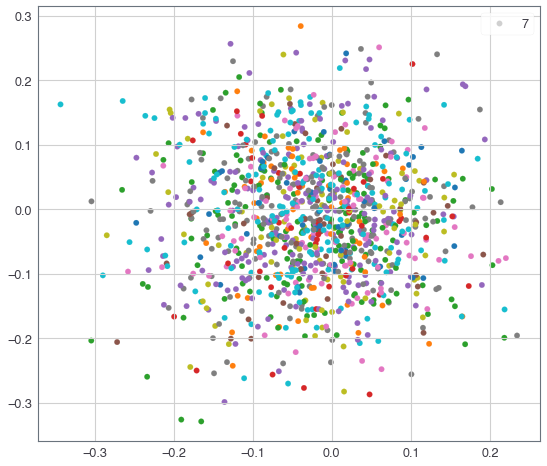

In [42]:
plt.figure(figsize = (9, 8))
plt.scatter(form['lstm.weight_ih_l0'][0], form['lstm.weight_ih_l0'][1], 
            c = labels[:-1], cmap = 'tab10')
plt.legend(labels)
plt.show()

In [43]:
form['lstm.weight_ih_l0']

tensor([[-1.6489e-01, -1.0402e-01, -8.0540e-02,  ..., -7.9148e-02,
         -7.6219e-02, -2.2801e-02],
        [ 7.7212e-02, -1.0611e-01, -5.4074e-02,  ...,  7.8973e-02,
          4.6437e-02, -3.1003e-02],
        [-1.6515e-01, -9.8594e-02, -4.5357e-02,  ...,  6.4936e-02,
         -2.3019e-02,  8.8729e-02],
        ...,
        [-1.5423e-01, -1.5379e-01, -2.9772e-02,  ..., -4.1261e-02,
          7.7825e-02,  5.1312e-02],
        [ 3.6318e-01,  1.2427e-02, -1.3259e-01,  ...,  4.9251e-02,
          7.1464e-02,  4.4806e-03],
        [ 2.6168e-04, -1.2268e-01, -1.3861e-01,  ..., -9.6304e-02,
          6.6021e-02, -5.4708e-02]])

In [55]:
be = trial_tuples(spikes, chunk_behavior = True, get_rt = True, lunacy = True)

UnboundLocalError: local variable 'neur_trl_slice' referenced before assignment

In [51]:
be

[[],
 [],
 (tensor([[0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          [0.0000, 0.5000],
          

evaluate the fp 

class LSTM(nn.Module):
    def __init__(self, input_size=n_neurons, hidden_layer_size=100, output_size=1):
        '''each input is a shit ton of 2 dimensional tensors containing c left and c right
        each output is a one dim tensor containing reaction time and choice.'''
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size, requires_grad= True),
                            torch.zeros(1,1,self.hidden_layer_size, requires_grad = True))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1),\
                                               self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1], self.hidden_cell 

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size=n_neurons, hidden_layer_size=100, output_size=2):
        '''each input is a shit ton of 2 dimensional tensors containing c left and c right
        each output is a one dim tensor containing reaction time and choice.'''
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1),\
                                               self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1], self.lstm.weight_ih_l0, self.hidden_cell

In [38]:
model = LSTM()

In [45]:
AHHH = np.array([])
for neur, behave in train_dat[0:50]:
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

    behave_pred, hidden_dynamics, hidden_cell = model(neur)
    #print(hidden_dynamics.shape)
    print(hidden_dynamics.shape)
    print(hidden_cell)
   # to_np = hidden_dynamics.detach().numpy()
   # AHHH = np.append(AHHH, axis = 0) 
    
print(AHHH.shape)
print(AHHH[0].shape)

torch.Size([400, 1143])
(tensor([[[-5.1661e-02, -1.3151e-01,  4.5643e-02,  2.1919e-01, -1.1130e-01,
           5.4707e-02, -1.7385e-02, -1.3964e-02, -1.1407e-01,  1.3811e-01,
           3.1425e-02,  8.6127e-02,  4.0454e-02,  7.0374e-02, -2.1046e-02,
          -3.7355e-01, -5.0311e-02, -4.4884e-02, -1.2578e-01, -3.3626e-02,
          -1.3652e-01,  3.7451e-01,  1.8882e-01,  3.8840e-01, -6.2819e-02,
           3.4953e-01, -2.0087e-01, -6.5870e-02,  5.3559e-04, -9.1649e-03,
          -2.8480e-01,  2.9359e-01,  6.5371e-02, -5.1535e-02, -8.3964e-02,
           2.8465e-01,  1.6266e-02,  9.7753e-02,  1.3489e-01,  6.3429e-02,
          -2.5250e-01, -1.0119e-01,  3.0220e-01, -2.4139e-01,  5.5924e-03,
           1.4138e-01,  2.4585e-01, -2.5377e-01, -7.3889e-02, -3.9223e-02,
          -2.1293e-01,  1.4972e-01,  3.8174e-01,  4.5275e-02, -1.7899e-01,
          -2.5944e-01,  9.3112e-02,  1.2580e-02, -9.3334e-02,  8.3869e-02,
           5.9456e-02,  1.0835e-01, -4.8042e-02,  1.1379e-01,  4.5916e-02,


torch.Size([400, 1143])
(tensor([[[-0.2223, -0.1670, -0.0710,  0.1777, -0.1349, -0.0390,  0.1318,
           0.2275,  0.2319,  0.2139, -0.0275,  0.2633,  0.0594,  0.1102,
          -0.1665, -0.2087, -0.1680,  0.1666, -0.1499, -0.1274,  0.0248,
          -0.1637,  0.2809,  0.2390, -0.1070,  0.1611,  0.1716,  0.2826,
          -0.2307,  0.0669, -0.0270,  0.3725,  0.0584, -0.0470, -0.1809,
           0.1708, -0.0776,  0.2757, -0.0394, -0.1452, -0.1765, -0.2896,
           0.1276, -0.2789, -0.2653,  0.1995, -0.1004, -0.2008, -0.0628,
          -0.1192,  0.3174,  0.2030, -0.1504,  0.2316,  0.0824, -0.2646,
          -0.1100,  0.4365, -0.2239,  0.1185,  0.1413, -0.1502, -0.0537,
           0.0378,  0.0357, -0.2903,  0.2922,  0.0399, -0.0656, -0.0212,
          -0.1682,  0.0114, -0.1101,  0.0378, -0.0500, -0.0670,  0.1027,
          -0.3213, -0.2990, -0.2726,  0.0284,  0.0378,  0.1501,  0.0208,
           0.0905, -0.0888,  0.2473,  0.0442,  0.0604,  0.0012, -0.0567,
          -0.2104,  0.1953

torch.Size([400, 1143])
(tensor([[[-0.1250,  0.0519, -0.0622,  0.1285,  0.0037, -0.1488,  0.1010,
           0.1772, -0.0487, -0.2452, -0.1349,  0.1949,  0.1514, -0.0608,
           0.0676, -0.1531, -0.1431, -0.2243, -0.0908,  0.0264, -0.0334,
          -0.1705,  0.0474,  0.1525,  0.0660,  0.4149,  0.1043, -0.0416,
          -0.2318,  0.0699, -0.0229,  0.2073, -0.2884, -0.3247,  0.2021,
           0.0185, -0.1579,  0.3329,  0.1466, -0.3000,  0.1267, -0.0456,
           0.3576, -0.1791, -0.0449,  0.0856,  0.3961, -0.2094, -0.3497,
           0.2850,  0.2346,  0.3073, -0.2186, -0.3344,  0.0414, -0.2822,
          -0.1262,  0.1142, -0.2120,  0.2709, -0.0023, -0.2442, -0.0717,
           0.2270, -0.2394,  0.0216,  0.0138,  0.0947, -0.0117,  0.0208,
          -0.1561, -0.1555,  0.0224,  0.0825,  0.0104,  0.1662,  0.2308,
          -0.0279, -0.1481, -0.1847, -0.2429, -0.1203,  0.0419, -0.0534,
          -0.0526, -0.1170,  0.0438,  0.0026, -0.2458, -0.0962,  0.0228,
          -0.1553,  0.1600

(tensor([[[-2.3708e-01, -2.1484e-01,  9.5410e-02,  1.3493e-01,  1.6075e-01,
          -3.0372e-02,  8.3525e-02,  5.9486e-02,  2.8314e-01, -2.6832e-01,
          -7.6894e-02,  1.5122e-01,  1.3458e-01,  1.3986e-02,  7.2724e-02,
          -2.5045e-01, -2.8833e-01,  2.2757e-01, -1.2644e-01,  1.4254e-02,
          -1.0683e-01, -2.3133e-01,  1.9458e-02,  8.0257e-02, -1.5377e-01,
          -1.3766e-04, -6.0185e-02,  3.1084e-01, -2.5739e-01, -1.3762e-01,
          -6.6864e-02,  1.2266e-01, -1.5764e-01, -1.1043e-01,  9.8347e-03,
           7.4073e-02, -2.1060e-01,  2.5290e-01, -5.6209e-02, -1.2470e-01,
          -2.2622e-01, -6.4004e-02,  4.2665e-01,  1.2994e-01, -2.4441e-01,
           1.9674e-01, -9.4830e-03, -7.9977e-02,  2.3073e-01, -1.2410e-01,
          -2.7764e-02, -1.0087e-01, -7.4098e-02,  5.2617e-02,  1.8396e-01,
           1.3484e-02, -4.2224e-02,  6.1319e-01,  1.9883e-01,  3.1206e-01,
           3.3829e-01, -7.5259e-02, -9.9754e-02, -1.1460e-01, -7.2080e-02,
          -3.0142e-02,  

(tensor([[[ 1.5448e-02, -1.0795e-01,  3.0090e-01,  5.2477e-01,  3.0894e-02,
          -1.1737e-02, -1.3106e-01,  1.3848e-01, -1.6353e-01, -3.6374e-03,
           1.1771e-01, -1.3187e-01,  6.0349e-02,  2.4536e-01,  3.7711e-02,
          -2.2637e-01, -1.7502e-01, -6.2919e-02,  1.5477e-01, -1.7452e-01,
          -1.5799e-01,  3.5297e-01,  6.1647e-02,  6.5152e-01, -1.4358e-01,
           3.5029e-01,  1.2205e-01, -1.0162e-02,  2.6129e-01, -2.7949e-02,
          -2.1022e-01,  1.1345e-01,  3.6466e-03, -2.2317e-01,  3.9815e-02,
          -1.6176e-02, -4.3944e-02, -2.0485e-02,  1.9676e-01, -2.7430e-01,
          -1.0077e-01, -3.0197e-01,  2.8665e-01, -5.1214e-01, -1.5398e-01,
           1.7382e-01,  3.4199e-01, -2.4739e-01, -7.4733e-02,  7.0199e-02,
           1.4848e-01,  2.9643e-01,  3.5391e-02,  5.4360e-02,  3.5373e-02,
          -2.4423e-01, -1.8358e-01, -1.6315e-01, -3.4065e-01,  1.4061e-01,
           2.6498e-02, -1.5960e-01, -4.3686e-02, -6.2151e-04, -1.4083e-01,
          -1.2951e-01,  

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
dim = pca.fit(AHHH)